# IMPORT LIBRARIES

In [64]:
import pandas as pd
from tkinter import Tk, filedialog, simpledialog
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# SET PLOT APPEARANCE

In [65]:
# Set font sizes
title_fontsize = 16
label_fontsize = 14
legend_fontsize = 14
tick_label_fontsize = 12

# IMPORT DATA AND PERFORM TEST

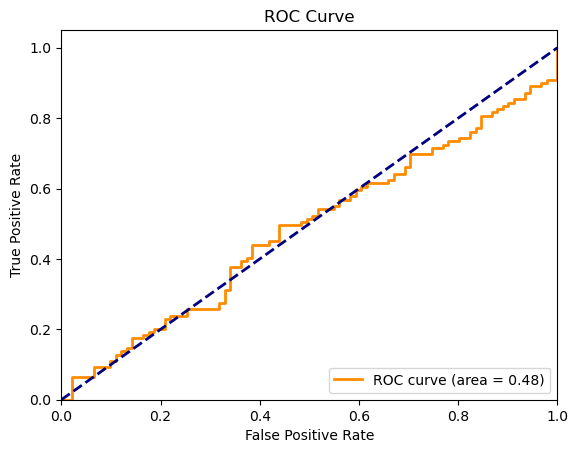

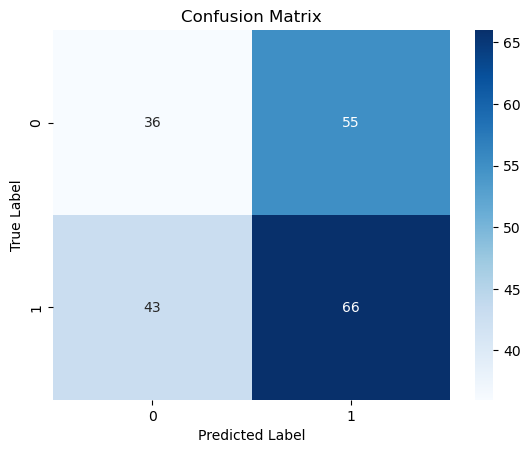

Accuracy: 0.51
Precision: 0.5454545454545454
Recall: 0.6055045871559633
F1-score: 0.5739130434782609

Confusion Matrix:
[[36 55]
 [43 66]]


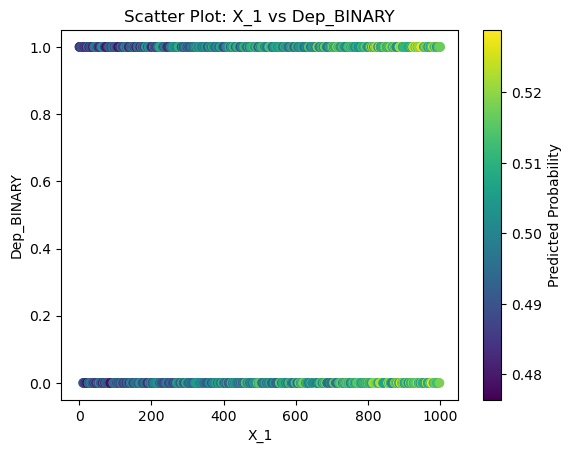

In [66]:
def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    try:
        df = pd.read_excel(file_path)
        df = df.dropna(axis=1, how='all')
        return df
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None

def get_file_path():
    """Open file dialog and return selected file path."""
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
    root.destroy()  # Close the Tkinter window
    return file_path

def get_user_column_selection(df, title):
    """Gets user input for selecting a column using dialog boxes."""
    columns = df.columns.tolist()
    root = Tk()
    root.withdraw()
    col_name = simpledialog.askstring(title, f"Enter the column name for {title}:\nAvailable columns: {', '.join(columns)}\n")
    root.destroy()  # Close the Tkinter window
    return col_name

def fit_logistic_regression(df, x_cols, y_col):
    # Prepare X and y
    X = df[x_cols]
    y = df[y_col]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    return model, X_test, y_test


def evaluate_model(model, X_test, y_test):
    """Evaluate the logistic regression model."""
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Confusion Matrix Heatmap
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1, conf_matrix

def plot_scatter(df, X_cols, y_col, logistic_model):
    """Plot scatter plot showing relationship between independent and target variables."""
    plt.figure()

    # Check if all X_cols are in the columns used during model training
    missing_cols = [col for col in X_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Columns '{', '.join(missing_cols)}' not found in the DataFrame.")
        return

    # Check if y_col is in the columns used during model training
    if y_col not in df.columns:
        print(f"Error: Column '{y_col}' not found in the DataFrame.")
        return

    X_test = df[X_cols]
    y_pred = logistic_model.predict_proba(X_test)[:, 1]
    
    plt.scatter(df[X_cols[0]], df[y_col], c=y_pred, cmap='viridis')
    plt.xlabel(X_cols[0])
    plt.ylabel(y_col)
    plt.title(f'Scatter Plot: {X_cols[0]} vs {y_col}')
    plt.colorbar(label='Predicted Probability')
    plt.show()

def main():
    file_path = get_file_path()
    if not file_path:
        print("No file selected.")
        return

    df = read_excel_file(file_path)
    if df is None:
        print("Error reading Excel file.")
        return

    # Get the number of independent variables from the user
    num_vars = simpledialog.askinteger("Number of Independent Variables", "Enter the number of independent variables:")
    if num_vars is None or num_vars <= 0:
        print("Invalid number of independent variables.")
        return

    x_cols = []  # List to store selected independent variables
    for _ in range(num_vars):
        x_col = get_user_column_selection(df, "Independent Variable (X)")
        if x_col is None:
            print("Error: Invalid input for independent variable.")
            return
        x_cols.append(x_col)

    y_col = get_user_column_selection(df, "Dependent Variable (Y)")
    if y_col is None:
        print("Error: Invalid input for dependent variable.")
        return

    logistic_model, X_test, y_test = fit_logistic_regression(df, x_cols, y_col)

    # Evaluate the model
    accuracy, precision, recall, f1, conf_matrix = evaluate_model(logistic_model, X_test, y_test)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plot scatter plot for one independent variable
    if len(x_cols) > 0:
        plot_scatter(df, x_cols, y_col, logistic_model)

if __name__ == "__main__":
    main()
